# Finpros Online Testing MSN

Author: Duong Huu Khoi\
Date: 24/02/2024\
Version: 5.0

## Import Libraries and Get Dataset 

In [1]:
# Import Libraries
import math
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Get the dataset
df = pd.read_csv('MSN.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0


## Preparing Dataset

In [3]:
#Check dataframe shape and empty values
print('Dataframe shape:',df.shape)
print('Null values:',df.isnull().values.any())

Dataframe shape: (135354, 8)
Null values: False


In [4]:
#Set index to Date/Time
df = df.set_index('Date/Time')

In [5]:
df.index

Index(['12/25/2017 9:15', '12/25/2017 9:16', '12/25/2017 9:18',
       '12/25/2017 9:20', '12/25/2017 9:21', '12/25/2017 9:22',
       '12/25/2017 9:23', '12/25/2017 9:27', '12/25/2017 9:30',
       '12/25/2017 9:36',
       ...
       '12/22/2020 14:18', '12/22/2020 14:19', '12/22/2020 14:20',
       '12/22/2020 14:21', '12/22/2020 14:22', '12/22/2020 14:23',
       '12/22/2020 14:24', '12/22/2020 14:25', '12/22/2020 14:27',
       '12/22/2020 14:46'],
      dtype='object', name='Date/Time', length=135354)

In [6]:
#Cast the index to datetime type instead of object
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2017-12-25 09:15:00', '2017-12-25 09:16:00',
               '2017-12-25 09:18:00', '2017-12-25 09:20:00',
               '2017-12-25 09:21:00', '2017-12-25 09:22:00',
               '2017-12-25 09:23:00', '2017-12-25 09:27:00',
               '2017-12-25 09:30:00', '2017-12-25 09:36:00',
               ...
               '2020-12-22 14:18:00', '2020-12-22 14:19:00',
               '2020-12-22 14:20:00', '2020-12-22 14:21:00',
               '2020-12-22 14:22:00', '2020-12-22 14:23:00',
               '2020-12-22 14:24:00', '2020-12-22 14:25:00',
               '2020-12-22 14:27:00', '2020-12-22 14:46:00'],
              dtype='datetime64[ns]', name='Date/Time', length=135354, freq=None)

<function matplotlib.pyplot.show(close=None, block=None)>

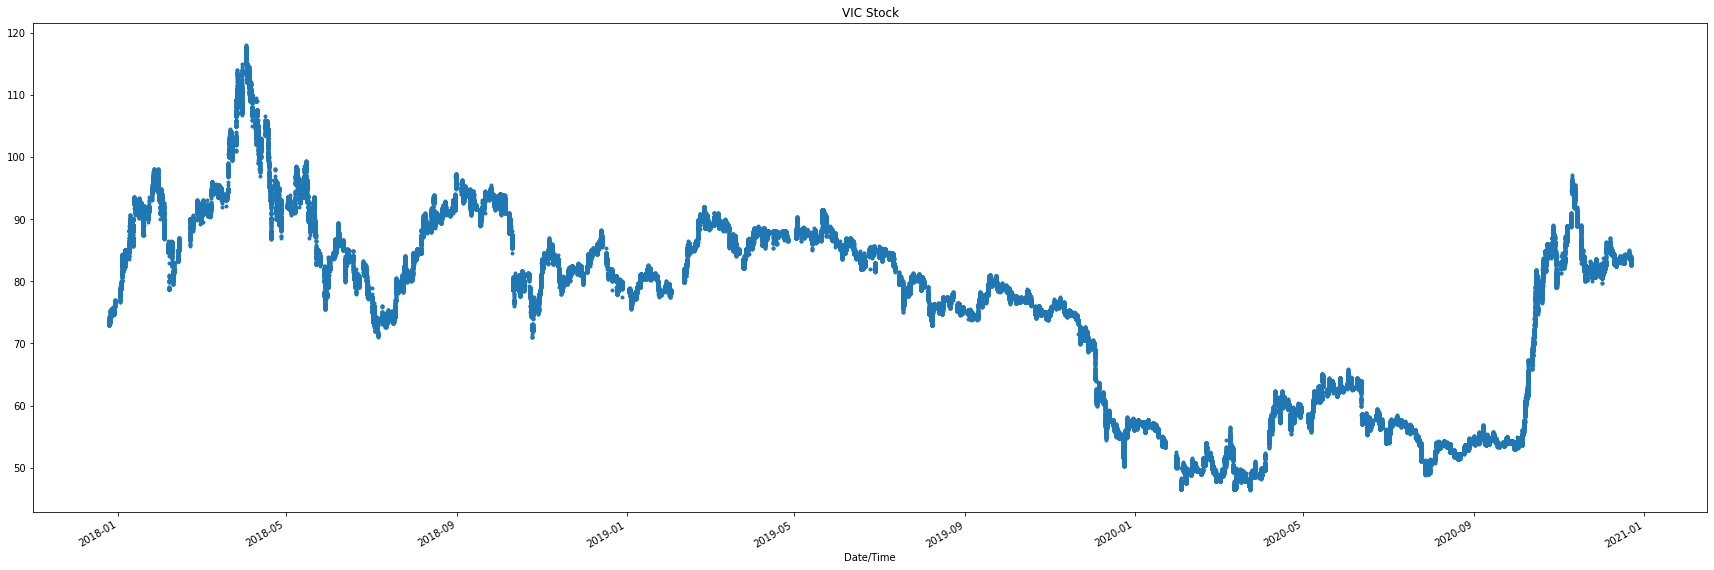

In [7]:
#Plot the dataset based on Date/Time and Close amount
df['Close'].plot(style = '.', figsize =  (30,10), title = 'VIC Stock')
plt.show

As we can see, there are missing values on the graph but when we check there is none. We can assume these are out of trading hours and prices will be the same as the previous timestamp and the trading volumes will be 0.

In [8]:
#Fill missing date with null value
df_resample = df.resample('min').asfreq()
print('Dataframe resample shape:',df_resample.shape)

Dataframe resample shape: (1574252, 7)


In [9]:
print('Null values:',df_resample.isnull().values.any())

Null values: True


In [10]:
#Fill out Open, Low, Close and with presvious timestamp
cols = ['Open', 'Low','High','Close','Ticker']
df_resample.loc[:,cols] = df_resample.loc[:,cols].ffill()

In [11]:
#Check empty rows
df_resample

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2017-12-25 09:15:00,MSN,73.1,73.1,73.1,73.1,4210.0,0.0
2017-12-25 09:16:00,MSN,73.0,73.0,73.0,73.0,5000.0,0.0
2017-12-25 09:17:00,MSN,73.0,73.0,73.0,73.0,NaN,NaN
2017-12-25 09:18:00,MSN,73.5,73.5,73.5,73.5,210.0,0.0
2017-12-25 09:19:00,MSN,73.5,73.5,73.5,73.5,NaN,NaN
...,...,...,...,...,...,...,...
2020-12-22 14:42:00,MSN,82.8,82.8,82.8,82.8,NaN,NaN
2020-12-22 14:43:00,MSN,82.8,82.8,82.8,82.8,NaN,NaN
2020-12-22 14:44:00,MSN,82.8,82.8,82.8,82.8,NaN,NaN


In [12]:
#Fill Volume and Open Interest with 0s since there is no trade happening 
df_resample['Volume'] = df_resample['Volume'].fillna(0)
df_resample['Open Interest'] = df_resample['Open Interest'].fillna(0)

In [13]:
#Check NaN values
df_resample.isna().sum()

Ticker           0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

## Build Model

In [14]:
#Create a new datafrane with Close
data = df_resample.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get number of rows for train data
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1259402

In [15]:
#Scale the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.37290503],
       [0.37150838],
       [0.37150838],
       ...,
       [0.50837989],
       [0.50837989],
       [0.50837989]])

In [16]:
#Create training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train
x_train = []
y_train = []

for i in range ( 60 , len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [17]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train),np.array(y_train)

In [18]:
#Reshape the x_train data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1259342, 60, 1)

In [19]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
#Compile model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
#Train the model
model.fit(x_train, y_train, batch_size = 200, epochs =2)

Epoch 1/2
6297/6297 [==============================] - 262s 40ms/step - loss: 1.0777e-04
Epoch 2/2
6297/6297 [==============================] - 155s 25ms/step - loss: 5.1583e-06


In [22]:
#Create testing data set
test_data = scaled_data[training_data_len - 60: , :]
#Create x_test and y_test
x_test = []
y_test = dataset[training_data_len: , :]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i ,0])

In [23]:
#Convert data to a numpy array
x_test = np.array(x_test)
x_test.shape

(314850, 60)

In [24]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(314850, 60, 1)

In [25]:
#Get the models prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [26]:
#Evaluate the model 
#Get RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('R2 Score: ',r2_score(y_test, predictions))
print('RMSE score:',rmse)

R2 Score:  0.9999411788763771
RMSE score: 0.03324442421990517


C:\Users\KHOIDU~1\AppData\Local\Temp/ipykernel_952/529889797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<function matplotlib.pyplot.show(close=None, block=None)>

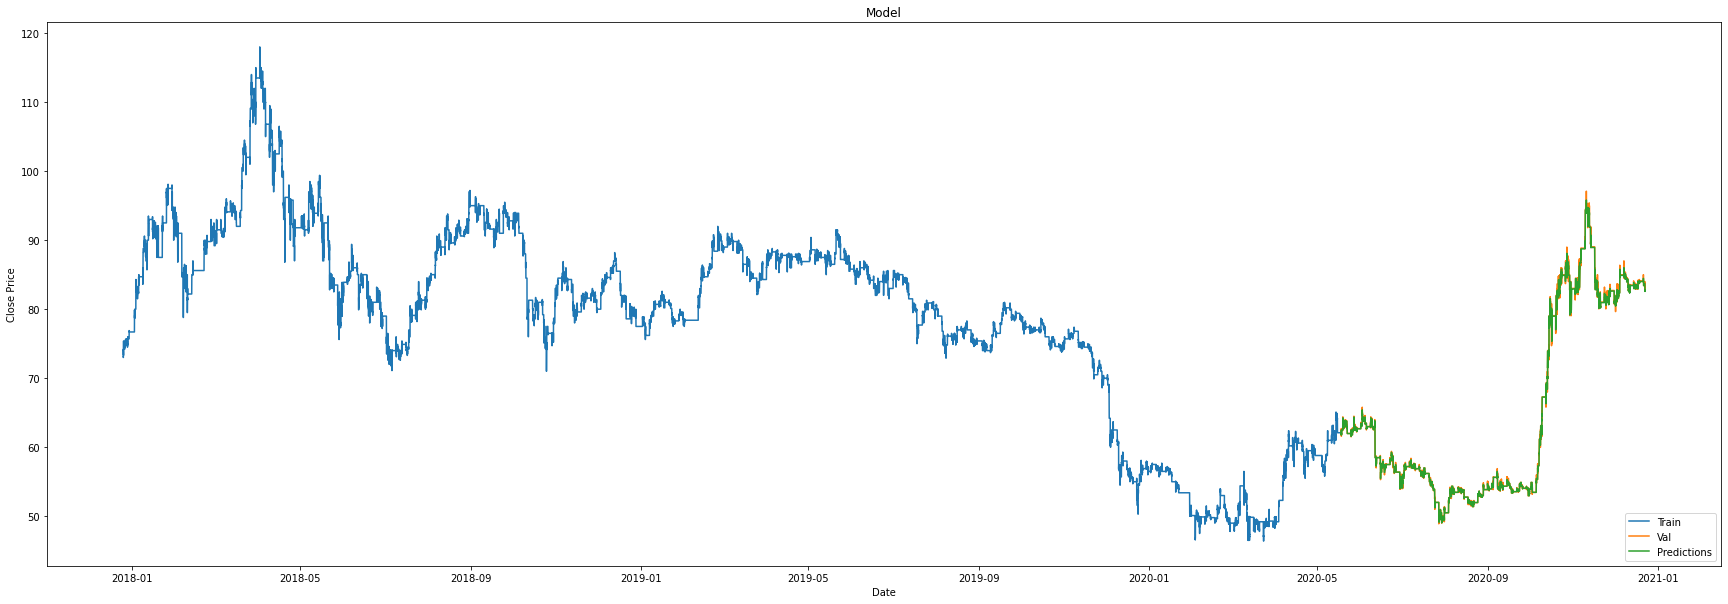

In [28]:
#Plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize = (30,10))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train' , 'Val', 'Predictions'], loc = 'lower right')
plt.show

In [29]:
def sliding_window(dataset,time):
    
    len_dataset=len(dataset)
    
    #Create a future input from test data with only 60 latest input
    future_inp  = dataset[(len_dataset-60):]
    
    #Create a temporary input from future input
    tmp_inp = list(future_inp)
    
    #Creating list of the last 60 data
    tmp_inp = tmp_inp[0].tolist()
    
    #Predicting next 30 days price suing the current data
    #It will predict in sliding window manner (algorithm) with stride 1
    lst_output=[]
    n_steps=60
    i=0
    while(i<time):
    
        if(len(tmp_inp)>60):
            future_inp = np.array(tmp_inp[1:])
            future_inp=future_inp.reshape(1,-1)
            future_inp = future_inp.reshape((1, n_steps, 1))
            yhat = model.predict(future_inp, verbose=0)
            tmp_inp.extend(yhat[0].tolist())
            tmp_inp = tmp_inp[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            future_inp = future_inp.reshape((1, n_steps,1))
            yhat = model.predict(future_inp, verbose=0)
            tmp_inp.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    lst_output = scaler.inverse_transform(lst_output)
    print("The change in stock price after", time,"minutes is:",lst_output[-1]-scaler.inverse_transform(dataset)[-1])

In [31]:
sliding_window(test_data,120)

The change in stock price after 120 minutes is: [-1.10675435]
